In [1]:
include("graph_ops.jl")
import Base: show, summary
show(io::IO, x::OperationNode{F}) where {F} = print(io, "op ", "?", "(", F, ")");
show(io::IO, x::ConstantNode) = print(io, "const ", x.output)
show(io::IO, x::VariableNode) = begin
    print(io, "var ", "?");
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

pprint(nodes::Vector{<:Node}) = for node in nodes; println(node); end


pprint (generic function with 1 method)

In [2]:
include("graph_ops.jl")

net = build_net(mean_squared_loss,
Dense( 1 => 50, tanh),
Dense( 50 => 1, nothing)
)

graph = net.graph
# pprint(graph)

new Dense: dims(Wx): (50, 1, " b: ", 50)
new Dense: dims(Wx): (1, 50, " b: ", 1)
input: InputNode([0.0], "?")
output: op ?(typeof(+))
DUUUPPAAA: (1,)


16-element Vector{Node}:
 const [0.5]
 var ?
 ┣━ ^ 1×50 Matrix{Float64}
 ┗━ ∇ 1×50 Matrix{Float64}
 var ?
 ┣━ ^ 50×1 Matrix{Float64}
 ┗━ ∇ 50×1 Matrix{Float64}
 InputNode([0.0], "?")
 op ?(typeof(mul!))
 var ?
 ┣━ ^ 50-element Vector{Float64}
 ┗━ ∇ 50-element Vector{Float64}
 op ?(typeof(+))
 op ?(typeof(tanh))
 op ?(typeof(mul!))
 var ?
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ 1-element Vector{Float64}
 op ?(typeof(+))
 InputNode([0.0], "?")
 op ?(typeof(-))
 const [2]
 op ?(typeof(^))
 op ?(typeof(*))

In [3]:
import Base: sin
data = [([i], [sin(i)]) for i in 0:0.1:7]

71-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0], [0.0])
 ([0.1], [0.09983341664682815])
 ([0.2], [0.19866933079506122])
 ([0.3], [0.29552020666133955])
 ([0.4], [0.3894183423086505])
 ([0.5], [0.479425538604203])
 ([0.6], [0.5646424733950354])
 ([0.7], [0.644217687237691])
 ([0.8], [0.7173560908995228])
 ([0.9], [0.7833269096274834])
 ⋮
 ([6.2], [-0.0830894028174964])
 ([6.3], [0.016813900484349713])
 ([6.4], [0.11654920485049364])
 ([6.5], [0.21511998808781552])
 ([6.6], [0.31154136351337786])
 ([6.7], [0.4048499206165983])
 ([6.8], [0.49411335113860816])
 ([6.9], [0.5784397643882002])
 ([7.0], [0.6569865987187891])

In [33]:
n_epochs = 1000
lr = 0.01
data_size = length(data)
losses = Float64[]
x = net.input
y = net.desired_output

@time for epoch in 1:n_epochs
    reset!(graph)
    loss_in_epoch = 0
    for (x_, y_) in data
        x.output = x_
        y.output = y_
        currentloss = forward!(graph)
        backward!(graph)
        loss_in_epoch += first(currentloss)
        # println("Current loss: ", currentloss)
    end
    # println(graph[2].gradient)
    adjust!(net.variables, lr/data_size)
    println("Current loss: ", loss_in_epoch/data_size)
    push!(losses, first(loss_in_epoch/data_size))
end


Current loss: 0.00040954178381627184
Current loss: 0.00040945949800736856
Current loss: 0.0004093772562630767
Current loss: 0.00040929505854990516
Current loss: 0.00040921290483441133
Current loss: 0.0004091307950831735
Current loss: 0.00040904872926281763
Current loss: 0.0004089667073399724
Current loss: 0.00040888472928130476
Current loss: 0.000408802795053522
Current loss: 0.000408720904623339
Current loss: 0.00040863905795752726
Current loss: 0.00040855725502285986
Current loss: 0.0004084754957861556
Current loss: 0.00040839378021424846
Current loss: 0.00040831210827401576
Current loss: 0.00040823047993235497
Current loss: 0.0004081488951562004
Current loss: 0.00040806735391249655
Current loss: 0.00040798585616824235
Current loss: 0.0004079044018904325
Current loss: 0.0004078229910461336
Current loss: 0.0004077416236023934
Current loss: 0.000407660299526329
Current loss: 0.00040757901878505775
Current loss: 0.00040749778134573957
Current loss: 0.0004074165871755577
Current loss: 0.

In [5]:
import Base: sin
data_dense_x = 0:0.1:7
data_dense_y = sin.(data_dense_x)

using Plots
xx = 0:0.01:7
yy = Vector{Float64}(undef, length(xx))

701-element Vector{Float64}:
 6.953009839825e-310
 6.95300983959416e-310
 6.953009839825e-310
 6.95300983959416e-310
 6.953009839825e-310
 6.95300983959416e-310
 6.574582302874e-312
 6.953009839825e-310
 6.95300983959416e-310
 6.953009839825e-310
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

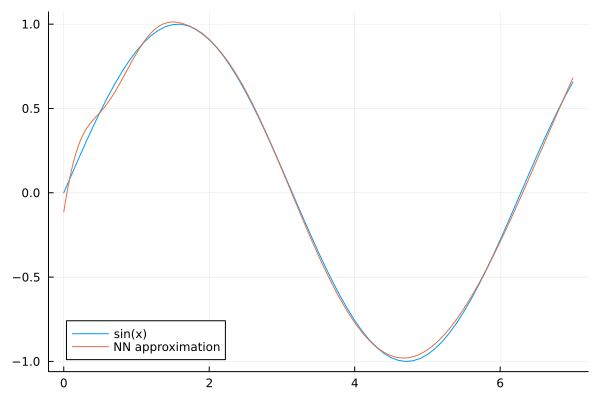

In [36]:


for i in 1:length(xx)
    yy[i] = predict!([xx[i]], x,net.output, graph)[1]
end

plot(data_dense_x, data_dense_y, label="sin(x)")
plot!(xx, yy, label="NN approximation")
